In [17]:
!pip install demoji
import demoji
demoji.download_codes()

In [18]:
!pip install google-generativeai

In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalMaxPool1D, Conv1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import pickle
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [23]:
# Define hate-only class mapping (excluding non_hate)
HATE_CLASS_MAPPING = {
    'sex_hate': 0,
    'other_hate': 1,
    'sports_hate': 2,
    'politics_hate': 3,
    'religious_hate': 4
}

In [24]:
REVERSE_HATE_CLASS_MAPPING = {v: k for k, v in HATE_CLASS_MAPPING.items()}

In [25]:
def simple_preprocess(text):
    """Simple and effective preprocessing"""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text).lower()
    
    # Remove URLs and mentions
    text = re.sub(r'http\S+|www\S+|@\w+', '', text)
    
    # Keep only letters, numbers and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text.strip())
    
    return text

In [26]:
def build_cnn_model(vocab_size, num_classes, embedding_dim=100, max_len=100):
    """Build CNN model - often better than LSTM for short text classification"""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Dropout(0.2),
        
        # Multiple CNN layers with different filter sizes
        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(64, 4, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(32, 5, activation='relu', padding='same'),
        BatchNormalization(),
        
        # Global max pooling
        GlobalMaxPool1D(),
        
        # Dense layers
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [27]:
def load_and_analyze_data(file_path):
    """Load data and analyze distribution"""
    
    try:
        data = pd.read_csv(file_path)
        print(f"Dataset loaded: {data.shape}")
        print(f"Columns: {data.columns.tolist()}")
        
        # Check for missing values
        print(f"\nMissing values:")
        print(data.isnull().sum())
        
        # Analyze hate categories
        print(f"\nHate category distribution:")
        print(data['hate_category'].value_counts())
        
        # Sample data
        print(f"\nSample data:")
        print(data.head())
        
        return data
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [28]:
def prepare_hate_classification_data(data, min_samples_per_class=100):
    """Prepare data for hate classification with proper validation"""
    
    # Filter out non_hate
    hate_data = data[data['hate_category'] != 'non_hate'].copy()
    print(f"After removing non_hate: {hate_data.shape}")
    
    # Check class distribution
    class_counts = hate_data['hate_category'].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    
    # Remove classes with too few samples
    valid_classes = class_counts[class_counts >= min_samples_per_class].index
    hate_data = hate_data[hate_data['hate_category'].isin(valid_classes)]
    
    print(f"\nAfter filtering low-frequency classes: {hate_data.shape}")
    print(f"Remaining classes: {hate_data['hate_category'].unique()}")
    
    # Clean data
    hate_data = hate_data.dropna(subset=['tweet', 'hate_category'])
    
    # Preprocess text
    print("Preprocessing text...")
    hate_data['cleaned_text'] = hate_data['tweet'].apply(simple_preprocess)
    
    # Remove empty text
    hate_data = hate_data[hate_data['cleaned_text'].str.len() > 0]
    
    print(f"Final dataset shape: {hate_data.shape}")
    print(f"Final class distribution:")
    print(hate_data['hate_category'].value_counts())
    
    return hate_data

In [29]:
def train_hate_classifier_improved(data, test_size=0.2, max_features=10000, max_len=100):
    """Improved training with proper validation"""
    
    # Prepare data
    X = data['cleaned_text'].values
    y_labels = data['hate_category'].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    y_categorical = to_categorical(y_encoded)
    
    num_classes = len(label_encoder.classes_)
    print(f"\nNumber of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Check if we have enough classes
    if num_classes < 2:
        print("ERROR: Not enough classes for classification!")
        return None, None, None
    
    # Prepare tokenizer
    tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(X)
    
    # Convert to sequences
    X_sequences = tokenizer.texts_to_sequences(X)
    X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post')
    
    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Sequence shape: {X_padded.shape}")
    
    # Split data
    X_train, X_test, y_train, y_test, y_enc_train, y_enc_test = train_test_split(
        X_padded, y_categorical, y_encoded, 
        test_size=test_size, 
        random_state=42, 
        stratify=y_encoded
    )
    
    print(f"\nTrain set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Check train distribution
    print(f"\nTrain set class distribution:")
    train_counts = np.bincount(y_enc_train)
    for i, count in enumerate(train_counts):
        class_name = label_encoder.inverse_transform([i])[0]
        print(f"{class_name}: {count}")
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_enc_train), 
        y=y_enc_train
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    print(f"\nClass weights: {class_weight_dict}")
    
    # Build model
    model = build_cnn_model(
        vocab_size=min(max_features, len(tokenizer.word_index)) + 1,
        num_classes=num_classes,
        max_len=max_len
    )
    
    print("\nModel architecture:")
    model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',  # Monitor accuracy instead of loss
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max'  # Maximize accuracy
        ),
        
        ModelCheckpoint(
            filepath='best_hate_classifier_cnn.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            mode='max',
            verbose=1
        )
    ]
    
    # Train model
    print(f"\nStarting training...")
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=50,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Load best model
    model = load_model('best_hate_classifier_cnn.h5')
    
    # Evaluate on test set
    print(f"\nEvaluating on test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Detailed predictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    target_names = [label_encoder.inverse_transform([i])[0] for i in range(num_classes)]
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title('Confusion Matrix - Hate Category Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save tokenizer and label encoder
    with open('hate_classifier_tokenizer.pickle', 'wb') as f:
        pickle.dump(tokenizer, f)
    
    with open('hate_classifier_labels.pickle', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    return model, tokenizer, label_encoder

In [30]:
class ImprovedHateClassifier:
    def __init__(self, 
                 model_path='best_hate_classifier_cnn.h5',
                 tokenizer_path='hate_classifier_tokenizer.pickle',
                 label_encoder_path='hate_classifier_labels.pickle',
                 max_len=100):
        
        self.max_len = max_len
        
        try:
            print("Loading model...")
            self.model = load_model(model_path)
            
            with open(tokenizer_path, 'rb') as f:
                self.tokenizer = pickle.load(f)
            
            with open(label_encoder_path, 'rb') as f:
                self.label_encoder = pickle.load(f)
            
            self.class_names = list(self.label_encoder.classes_)
            print(f"Model loaded successfully!")
            print(f"Classes: {self.class_names}")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    
    def predict(self, text):
        """Predict hate category"""
        
        # Preprocess
        cleaned_text = simple_preprocess(text)
        
        if not cleaned_text:
            return "other_hate", 0.0, "Low", {}
        
        # Convert to sequence
        sequence = self.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = pad_sequences(sequence, maxlen=self.max_len, padding='post')
        
        # Predict
        prob_dist = self.model.predict(padded_sequence, verbose=0)[0]
        predicted_idx = np.argmax(prob_dist)
        predicted_class = self.label_encoder.inverse_transform([predicted_idx])[0]
        confidence_score = float(prob_dist[predicted_idx])
        
        # Confidence level
        if confidence_score > 0.7:
            confidence = "High"
        elif confidence_score > 0.5:
            confidence = "Medium"
        else:
            confidence = "Low"
        
        # All probabilities
        prob_dict = {self.class_names[i]: float(prob_dist[i]) 
                    for i in range(len(self.class_names))}
        
        return predicted_class, confidence_score, confidence, prob_dict
    
    def batch_predict(self, texts):
        """Batch prediction for efficiency"""
        
        # Preprocess all texts
        cleaned_texts = [simple_preprocess(text) for text in texts]
        
        # Convert to sequences
        sequences = self.tokenizer.texts_to_sequences(cleaned_texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        
        # Batch prediction
        prob_dists = self.model.predict(padded_sequences, verbose=0)
        
        results = []
        for i, (original_text, prob_dist) in enumerate(zip(texts, prob_dists)):
            predicted_idx = np.argmax(prob_dist)
            predicted_class = self.label_encoder.inverse_transform([predicted_idx])[0]
            confidence_score = float(prob_dist[predicted_idx])
            
            if confidence_score > 0.7:
                confidence = "High"
            elif confidence_score > 0.5:
                confidence = "Medium"
            else:
                confidence = "Low"
            
            prob_dict = {self.class_names[j]: float(prob_dist[j]) 
                        for j in range(len(self.class_names))}
            
            results.append({
                'text': original_text,
                'predicted_category': predicted_class,
                'confidence_score': confidence_score,
                'confidence_level': confidence,
                'all_probabilities': prob_dict
            })
        
        return results

In [31]:
def main():
    """Main training and testing pipeline"""
    
    # Load data
    print("Loading data...")
    data = load_and_analyze_data("/kaggle/input/subcategory-hate-content/sub-category-hate-content.csv")
    
    if data is None:
        print("Failed to load data!")
        return
    
    # Prepare data
    print("\nPreparing data...")
    hate_data = prepare_hate_classification_data(data)
    
    if hate_data.shape[0] == 0:
        print("No data available for training!")
        return
    
    # Train model
    print("\nTraining model...")
    model, tokenizer, label_encoder = train_hate_classifier_improved(hate_data)
    
    if model is None:
        print("Training failed!")
        return
    
    print("\nTraining completed successfully!")
    
    # Test the classifier
    try:
        classifier = ImprovedHateClassifier()
        
        test_samples = [
            "Women belong in the kitchen not in the workplace",  # sex_hate
            "That team is full of cheating losers",  # sports_hate  
            "All politicians should be thrown in jail",  # politics_hate
            "Those religious fanatics are destroying society",  # religious_hate
            "You're the biggest idiot I've ever seen",  # other_hate
        ]
        
        print("\nTesting classifier:")
        print("="*60)
        
        for text in test_samples:
            pred_class, conf_score, conf_level, probs = classifier.predict(text)
            
            print(f"\nText: {text}")
            print(f"Prediction: {pred_class}")
            print(f"Confidence: {conf_score:.3f} ({conf_level})")
            
            # Top 2 predictions
            sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:2]
            print("Top predictions:")
            for cat, prob in sorted_probs:
                print(f"  {cat}: {prob:.3f}")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error testing classifier: {e}")



Loading data...
Dataset loaded: (24783, 2)
Columns: ['tweet', 'hate_category']

Missing values:
tweet            0
hate_category    0
dtype: int64

Hate category distribution:
hate_category
sex_hate          12549
other_hate         8583
non_hate           2872
sports_hate         269
politics_hate       256
religious_hate      254
Name: count, dtype: int64

Sample data:
                                               tweet hate_category
0  !!! RT @mayasolovely: As a woman you shouldn't...      non_hate
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      sex_hate
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      sex_hate
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...    other_hate
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      sex_hate

Preparing data...
After removing non_hate: (21911, 2)

Class distribution:
hate_category
sex_hate          12549
other_hate         8583
sports_hate         269
politics_hate       256
religious_hate      254
Name: count, d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/50


I0000 00:00:1753113324.455144     109 service.cc:148] XLA service 0x7f0824002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753113324.455990     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753113324.456010     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753113325.217612     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/220 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1998 - loss: 3.3093

I0000 00:00:1753113332.072416     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2134 - loss: 3.1264
Epoch 1: val_accuracy improved from -inf to 0.38021, saving model to best_hate_classifier_cnn.h5
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.2135 - loss: 3.1253 - val_accuracy: 0.3802 - val_loss: 1.7972 - learning_rate: 0.0010
Epoch 2/50
216/220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2454 - loss: 2.5094
Epoch 2: val_accuracy did not improve from 0.38021
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2451 - loss: 2.5085 - val_accuracy: 0.3802 - val_loss: 2.1579 - learning_rate: 0.0010
Epoch 3/50
210/220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2924 - loss: 2.2548
Epoch 3: val_accuracy improved from 0.38021 to 0.39076, saving model to best_hate_classifier_cnn.h5
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2934 - loss: 2.2526 - val_accuracy: 0.3908 - val_loss: 1.7268 - learning_rate: 0.0010
Epoch 4/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5123 - loss: 

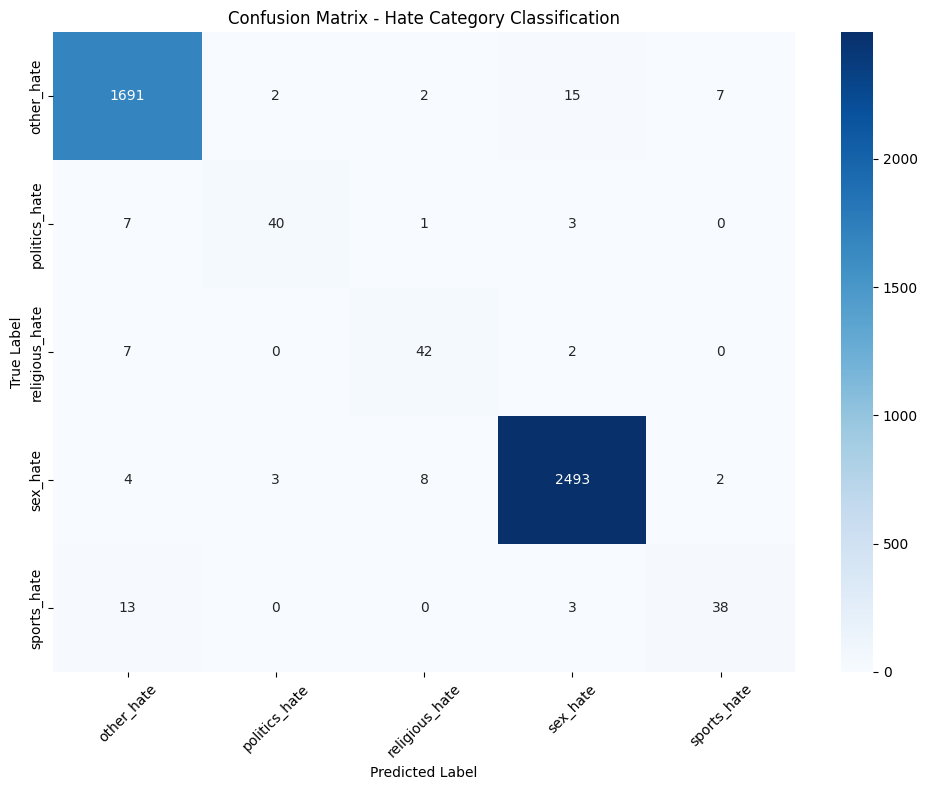

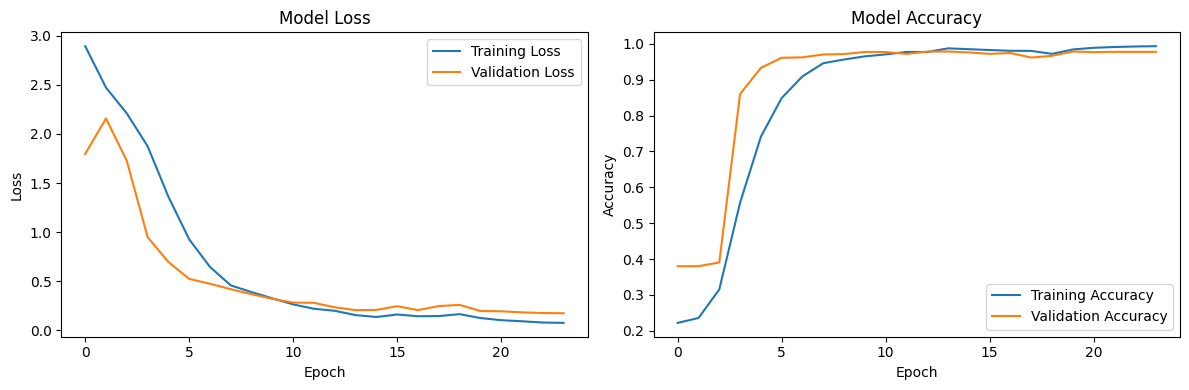


Training completed successfully!
Loading model...
Model loaded successfully!
Classes: ['other_hate', 'politics_hate', 'religious_hate', 'sex_hate', 'sports_hate']

Testing classifier:

Text: Women belong in the kitchen not in the workplace
Prediction: other_hate
Confidence: 1.000 (High)
Top predictions:
  other_hate: 1.000
  sex_hate: 0.000
----------------------------------------

Text: That team is full of cheating losers
Prediction: sports_hate
Confidence: 1.000 (High)
Top predictions:
  sports_hate: 1.000
  other_hate: 0.000
----------------------------------------

Text: All politicians should be thrown in jail
Prediction: other_hate
Confidence: 1.000 (High)
Top predictions:
  other_hate: 1.000
  sex_hate: 0.000
----------------------------------------

Text: Those religious fanatics are destroying society
Prediction: religious_hate
Confidence: 0.998 (High)
Top predictions:
  religious_hate: 0.998
  sex_hate: 0.001
----------------------------------------

Text: You're the bigges

In [32]:
if __name__ == "__main__":
    main()